## Calculations and plots for blog post 

### AMD TR 3990x vs 3970x Performance and  Scaling 

These are typical imports I do for almost any data analysis

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set() # not using seaborn but this makes the plots look better
%matplotlib inline

- **Performance data**  HPL: GFLOP/s, Numpy norm(A@B): seconds to complete, NAMD: day/ns
- **Scaling data** (job perf in seconds  vs number of CPU cores)

## HPL 3990x vs 3970x Performance

In [83]:
dfhpl = pd.DataFrame({'CPU':[
    'TR 3990x 64-core AVX2 BLIS v2.0',
    'TR 3970x 32-Core AVX2 BLIS v2.0'
     ], 
    'GFLOP/s':[1571, 1326 ]})
dfhpl

,CPU,GFLOP/s
0,TR 3990x 64-core AVX2 BLIS v2.0,1571
1,TR 3970x 32-Core AVX2 BLIS v2.0,1326


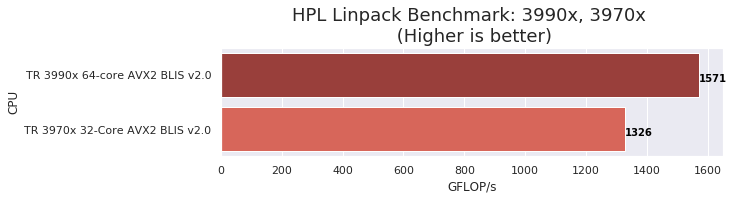

In [86]:
plt.figure(figsize=(9,2))

clrs = sns.color_palette("Reds_d", 2)
#print(clrs)
#clrs[0]=sns.xkcd_rgb["red"]
#clrs[1]=sns.xkcd_rgb["red"]

ax = sns.barplot(y="CPU", x="GFLOP/s", data=dfhpl, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('HPL Linpack Benchmark: 3990x, 3970x \n (Higher is better)', fontsize=18)

y = dfhpl['GFLOP/s']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## TR 3990x  HPL Scaling

In [60]:
hpl = np.array([12064,6334,3652,1980,1139,861,724,647,619,601,599])
hpl = hpl[0]/hpl
hpl

array([ 1.        ,  1.90464162,  3.3033954 ,  6.09292929, 10.59174715,
       14.0116144 , 16.66298343, 18.64605873, 19.48949919, 20.07321131,
       20.14023372])

In [61]:
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])

This is Amdhal's Law equation that I will "fit" the data to.

In [62]:
def amdhal(n,P):
    return hpl[0]/((1-P)+(P/n))

This is the curve fit. Really easy using scipy!  
popt is the optimized parameter P and pcov is the 
covarience which is just a statistics measure that I don't need
but I need a variable for it since it is part of the output from 
that command.

In [63]:
popt, pcov = curve_fit(amdhal, numcores, hpl)

In [64]:
popt

array([0.96793092])

## TR 3970x HPL Scaling

In [65]:
# data for 3970x 32 core
hpl32 = np.array([12111,6162,3297,1720,1143,1068,951])
hpl32 = hpl32[0]/hpl32
print(hpl32)

def amdhal32(n,P):
    return hpl32[0]/((1-P)+(P/n))
popt32, pcov32 = curve_fit(amdhal32, numcores[:7], hpl32)
popt32

[ 1.          1.9654333   3.6733394   7.04127907 10.59580052 11.33988764
 12.73501577]


array([0.95417126])

#### This mess generates the plots with matplotlib

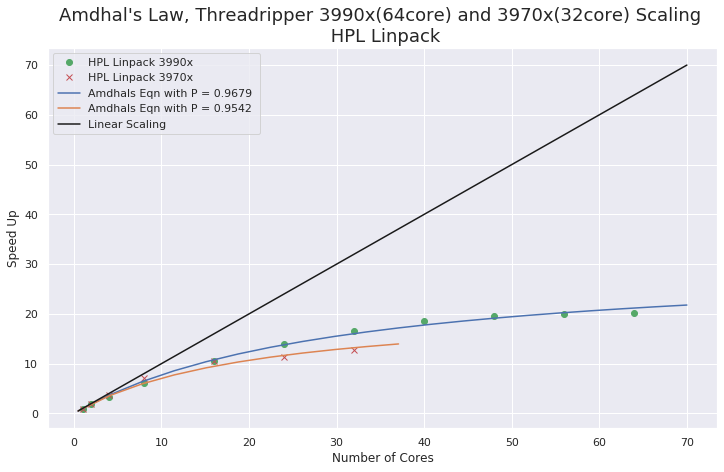

In [67]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, hpl, "o", color='g', label='HPL Linpack 3990x')  # plot the test data
ax.plot( numcores[:7], hpl32, "x", color='r', label='HPL Linpack 3970x') 

xt = np.linspace(0.5,70,20)

ax.plot(xt, amdhal(xt,popt)  ,  label='Amdhals Eqn with P = %.4f ' %(popt[0]))  # plot the model function
ax.plot(xt[:11], amdhal32(xt[:11],popt32)  ,  label='Amdhals Eqn with P = %.4f ' %(popt32[0]))

ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x(64core) and 3970x(32core) Scaling \n HPL Linpack", fontsize=18)
ax.legend()

The next line is the maximum scaling possible

In [53]:
1/(1-popt)

array([31.18268256])

The next couple of cells you see why I used numpy arrays ... I was able to do these calculations on the arrays in 1 operation rather than needing to loop over them.
The first one divids all terms in the array wps by the first term. That gives the "speedup"

The next cell takes the result from the previous cell (that's what the _ means) and divided the entries in that array by the array [1,2,4,6,8] and multiplies by 100 to give the % efficiency.  

## Numpy OpenBLAS norm(A@B)  3990x vs 3970x Performance

In [88]:
dfnorm = pd.DataFrame({'CPU':[
    'TR 3990x 64-core numpy OpenBLAS',
    'TR 3970x 32-Core numpy OpenBLAS'
     ], 
    'Seconds':[11.4, 13.5 ]})
dfnorm

,CPU,Seconds
0,TR 3990x 64-core AVX2 BLIS v2.0,11.4
1,TR 3970x 32-Core AVX2 BLIS v2.0,13.5


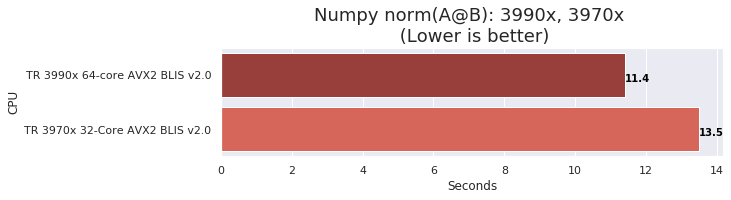

In [89]:
plt.figure(figsize=(9,2))

clrs = sns.color_palette("Reds_d", 2)
#print(clrs)
#clrs[0]=sns.xkcd_rgb["red"]
#clrs[1]=sns.xkcd_rgb["red"]

ax = sns.barplot(y="CPU", x="Seconds", data=dfnorm, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('Numpy norm(A@B): 3990x, 3970x \n (Lower is better)', fontsize=18)

y = dfnorm['Seconds']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## Numpy OpenBLAS norm(A@B) 3990x vs 3970x Scaling 

In [68]:
matnorm = np.array([341,171,86,44,23,17,14,12,11.4,11.2,11.5])
matnorm = matnorm[0]/matnorm
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])
matnorm

array([ 1.        ,  1.99415205,  3.96511628,  7.75      , 14.82608696,
       20.05882353, 24.35714286, 28.41666667, 29.9122807 , 30.44642857,
       29.65217391])

In [69]:
def amdhal(n,P):
    return matnorm[0]/((1-P)+(P/n))

popt, pcov = curve_fit(amdhal, numcores, matnorm)
popt

array([0.98552062])

In [70]:
# data for 3970x 32 core
matnorm32 = np.array([335.9,167.8,84.7,43.3,23.0,16.3,13.5])
matnorm32 = matnorm32[0]/matnorm32
print(matnorm32)

def amdhal32(n,P):
    return matnorm32[0]/((1-P)+(P/n))
popt32, pcov32 = curve_fit(amdhal32, numcores[:7], matnorm32)
popt32

[ 1.          2.00178784  3.96576151  7.75750577 14.60434783 20.60736196
 24.88148148]


array([0.99153144])

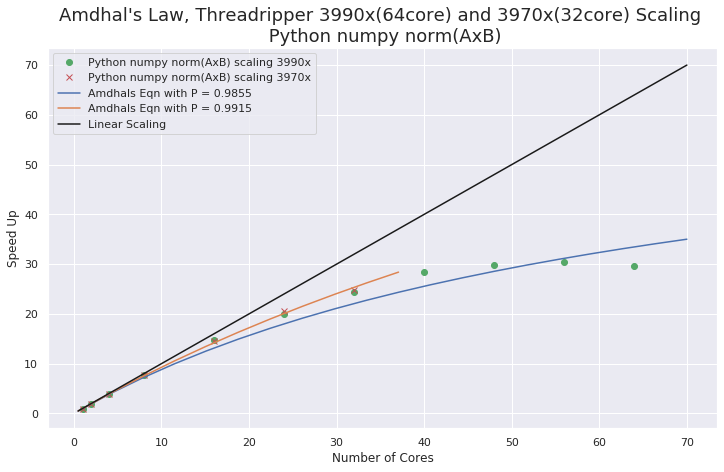

In [71]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, matnorm, "o", color='g', label='Python numpy norm(AxB) scaling 3990x')  # plot the test data
ax.plot( numcores[:7], matnorm32, "x", color='r', label='Python numpy norm(AxB) scaling 3970x')

xt = np.linspace(0.5,70,20)
ax.plot(xt, amdhal(xt,popt)  ,  label='Amdhals Eqn with P = %.4f ' %(popt[0]))  # plot the model function
ax.plot(xt[:11], amdhal32(xt[:11],popt32)  ,  label='Amdhals Eqn with P = %.4f ' %(popt32[0]))

ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x(64core) and 3970x(32core) Scaling \n Python numpy norm(AxB)", fontsize=18)
ax.legend()

In [59]:
1/(1-popt)

array([69.06371897])

## NAMD ApoA1  3990x vs 3970x Performance

In [90]:
dfapoa1 = pd.DataFrame({'CPU':[
    'TR 3990x 64-core + (2)NVIDIA RTX Titan',
    'TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti',
    'TR 3990x 64-core + 64-SMT',
    'TR 3970x 32-Core + 32-SMT'
     ], 
    'day/ns':[ 0.0201,0.01933,0.1325,0.1874]})
dfapoa1

,CPU,day/ns
0,TR 3990x 64-core + (2)NVIDIA RTX Titan,0.02010
1,TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti,0.01933
2,TR 3990x 64-core + 64-SMT,0.13250
3,TR 3970x 32-Core + 32-SMT,0.18740


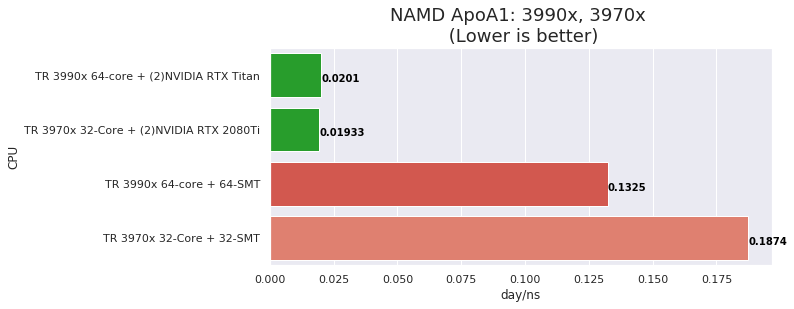

In [91]:
plt.figure(figsize=(9,4))

clrs = sns.color_palette("Reds_d", 4)
#print(clrs)
clrs[0]=sns.xkcd_rgb["green"]
clrs[1]=sns.xkcd_rgb["green"]

ax = sns.barplot(y="CPU", x="day/ns", data=dfapoa1, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('NAMD ApoA1: 3990x, 3970x \n (Lower is better)', fontsize=18)

y = dfapoa1['day/ns']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## NAMD ApoA1  3990x vs 3970x Scaling

In [72]:
apoa1 = np.array([267,136,70,37,20,14,11.3,9.7,8.2,7.7,7.5])
apoa1 = apoa1[0]/apoa1
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])
apoa1

array([ 1.        ,  1.96323529,  3.81428571,  7.21621622, 13.35      ,
       19.07142857, 23.62831858, 27.5257732 , 32.56097561, 34.67532468,
       35.6       ])

In [73]:
def amdhal(n,P):
    return apoa1[0]/((1-P)+(P/n))

popt, pcov = curve_fit(amdhal, numcores, apoa1)
popt

array([0.98842866])

In [74]:
# data for 3970x 32 core
apoa132 = np.array([261.0,132.6,68.9,36.0,19.1,13.3,10.8])
apoa132 = apoa132[0]/apoa132
print(apoa132)

def amdhal32(n,P):
    return apoa132[0]/((1-P)+(P/n))
popt32, pcov32 = curve_fit(amdhal32, numcores[:7], apoa132)
popt32

[ 1.          1.96832579  3.78809869  7.25       13.66492147 19.62406015
 24.16666667]


array([0.9896649])

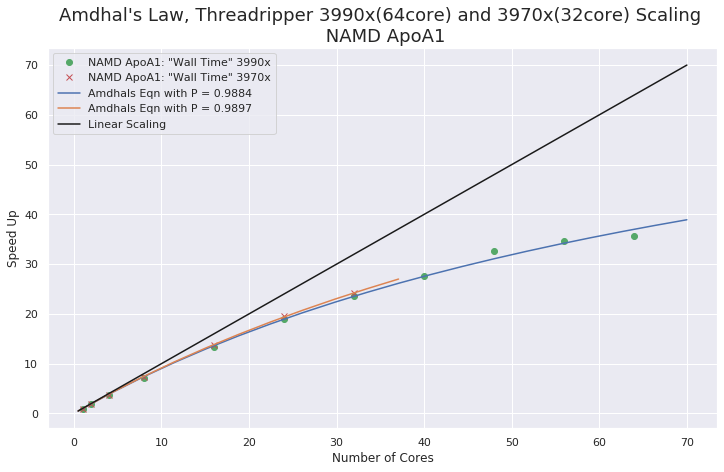

In [75]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, apoa1, "o", color='g', label='NAMD ApoA1: "Wall Time" 3990x')  # plot the test data
ax.plot( numcores[:7], apoa132, "x", color='r', label='NAMD ApoA1: "Wall Time" 3970x')

xt = np.linspace(0.5,70,20)
ax.plot(xt, amdhal(xt,popt)  ,  label='Amdhals Eqn with P = %.4f ' %(popt[0]))  # plot the model function
ax.plot(xt[:11], amdhal32(xt[:11],popt32)  ,  label='Amdhals Eqn with P = %.4f ' %(popt32[0]))

ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x(64core) and 3970x(32core) Scaling \n NAMD ApoA1", fontsize=18)
ax.legend()

In [63]:
1/(1-popt)

array([86.42043539])

## NAMD STMV  3990x vs 3970x Performance

In [94]:
dfstmv = pd.DataFrame({'CPU':[
    'TR 3990x 64-core + (2)NVIDIA RTX Titan',
    'TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti',
    'TR 3990x 64-core + 64-SMT',
    'TR 3970x 32-Core + 32-SMT'
     ], 
    'day/ns':[ 0.3061,0.3511,1.601,2.124]})
dfstmv

,CPU,day/ns
0,TR 3990x 64-core + (2)NVIDIA RTX Titan,0.3061
1,TR 3970x 32-Core + (2)NVIDIA RTX 2080Ti,0.3511
2,TR 3990x 64-core + 64-SMT,1.6010
3,TR 3970x 32-Core + 32-SMT,2.1240


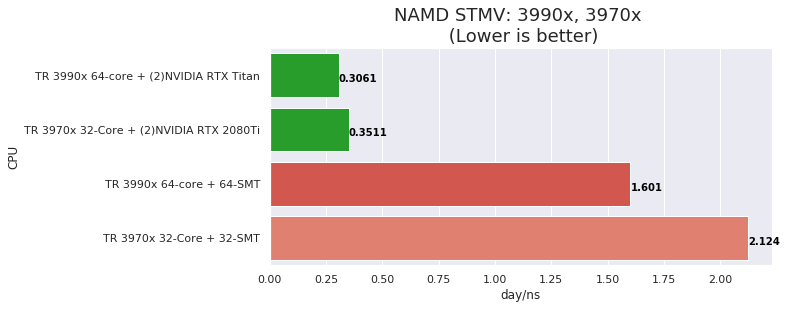

In [95]:
plt.figure(figsize=(9,4))

clrs = sns.color_palette("Reds_d", 4)
#print(clrs)
clrs[0]=sns.xkcd_rgb["green"]
clrs[1]=sns.xkcd_rgb["green"]

ax = sns.barplot(y="CPU", x="day/ns", data=dfstmv, palette=clrs)
#ax.set_xlim(100,320)
ax.set_title('NAMD STMV: 3990x, 3970x \n (Lower is better)', fontsize=18)

y = dfstmv['day/ns']
for i, v in enumerate(y):
    ax.text(v , i + .125, str(v), color='black', fontweight='bold')

## NAMD STMV  3990x vs 3970x Scaling

In [76]:
stmv = np.array([2934,1478,763,398,212,148,120,103,92,85,79])
stmv = stmv[0]/stmv
numcores = np.array([1,2,4,8,16,24,32,40,48,56,64])
stmv

array([ 1.        ,  1.98511502,  3.84534731,  7.3718593 , 13.83962264,
       19.82432432, 24.45      , 28.48543689, 31.89130435, 34.51764706,
       37.13924051])

In [77]:
def amdhal(n,P):
    return stmv[0]/((1-P)+(P/n))

popt, pcov = curve_fit(amdhal, numcores, stmv)
popt

array([0.9889665])

In [78]:
# data for 3970x 32 core
stmv32 = np.array([2846,1440,744,387.5,204.6,144.5,114.2])
stmv32 = stmv32[0]/stmv32
print(stmv32)

def amdhal32(n,P):
    return stmv32[0]/((1-P)+(P/n))
popt32, pcov32 = curve_fit(amdhal32, numcores[:7], stmv32)
popt32

[ 1.          1.97638889  3.82526882  7.34451613 13.91006843 19.69550173
 24.92119089]


array([0.99067684])

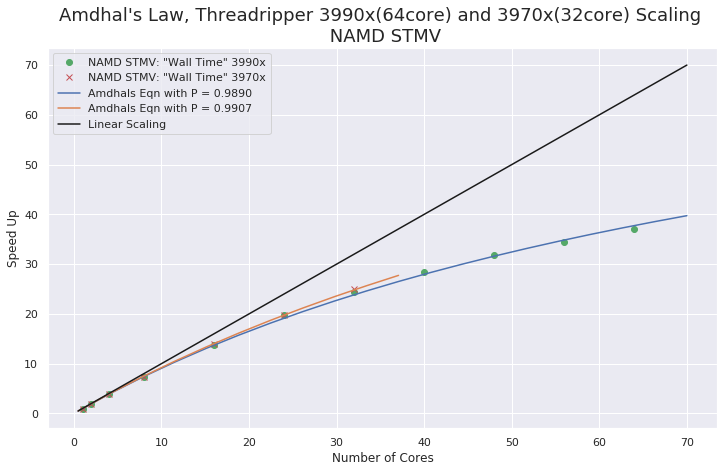

In [81]:
plt.rcParams["figure.figsize"] = [12,7]
#plt.figure(figsize=(16,9))
fig, ax = plt.subplots()
ax.plot( numcores, stmv, "o", color='g', label='NAMD STMV: "Wall Time" 3990x')  # plot the test data
ax.plot( numcores[:7], stmv32, "x", color='r', label='NAMD STMV: "Wall Time" 3970x')

xt = np.linspace(0.5,70,20)
ax.plot(xt, amdhal(xt,popt)  ,  label='Amdhals Eqn with P = %.4f ' %(popt[0]))  # plot the model function
ax.plot(xt[:11], amdhal32(xt[:11],popt32)  ,  label='Amdhals Eqn with P = %.4f ' %(popt32[0]))

ax.plot(xt,hpl[0]*xt, color='k', label='Linear Scaling')

plt.xlabel("Number of Cores")
plt.ylabel("Speed Up")
plt.title("Amdhal's Law, Threadripper 3990x(64core) and 3970x(32core) Scaling \n NAMD STMV", fontsize=18)
ax.legend()